In [40]:
import torch
from pytorch_metric_learning import losses
import data_handler
from siamese_network import SiameseNetwork, train
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader
from custom_losses import ContrastiveLoss
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
torch.zeros(1).cuda()
#print(f"torch version: {torch.__version__}")

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"torch cuda available: {torch.cuda.is_available()}")

torch cuda available: True


# Data Management

In [54]:
df_data, _ = data_handler.load(path="dataset/", filename_train="train.csv", sep_char='#')

In [55]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20635 entries, 0 to 20634
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   argument   20635 non-null  object 
 1   key_point  20635 non-null  object 
 2   topic      20635 non-null  object 
 3   label      20635 non-null  float64
dtypes: float64(1), object(3)
memory usage: 645.0+ KB


In [56]:
df_data['label'].value_counts()

0.0    16375
1.0     4260
Name: label, dtype: int64

<AxesSubplot: title={'center': 'Labels Proportions in Dataset'}>

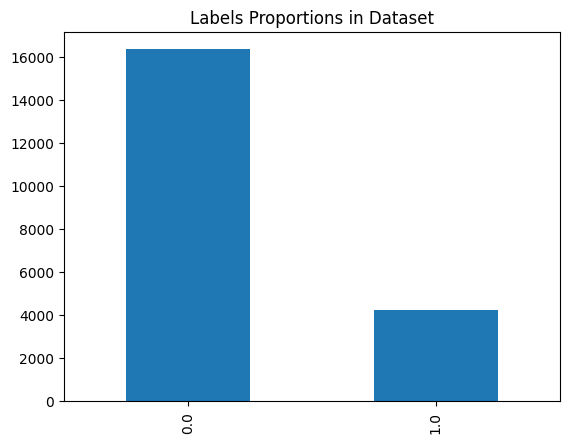

In [57]:
df_data['label'].value_counts().plot.bar(title='Labels Proportions in Dataset')

In [67]:
# Perform a stratified split dividing it into 80% training set and 20% validation set
df_train, df_val = data_handler.split_train_data(df_data, perc_split=0.8)

zero_train:  13100
one_train:  3408
zero_val:  3275
one_val:  852


In [68]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16508 entries, 0 to 16471
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   argument   16508 non-null  object 
 1   key_point  16508 non-null  object 
 2   topic      16508 non-null  object 
 3   label      16508 non-null  float64
dtypes: float64(1), object(3)
memory usage: 644.8+ KB


In [69]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4127 entries, 16520 to 20634
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   argument   4127 non-null   object 
 1   key_point  4127 non-null   object 
 2   topic      4127 non-null   object 
 3   label      4127 non-null   float64
dtypes: float64(1), object(3)
memory usage: 161.2+ KB


<AxesSubplot: title={'center': 'Labels Proportions in Training set'}>

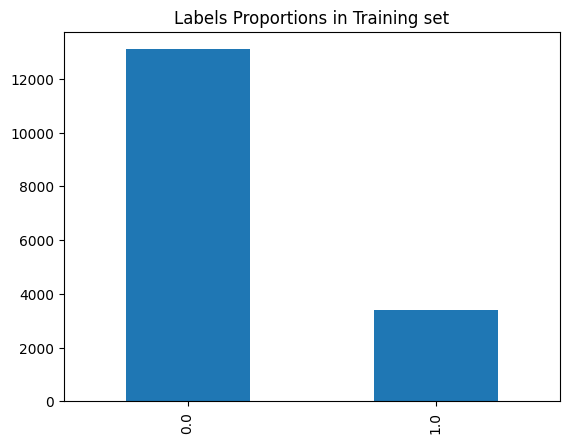

In [70]:
df_train['label'].value_counts().plot.bar(title='Labels Proportions in Training set')

<AxesSubplot: title={'center': 'Labels Proportions in Validation set'}>

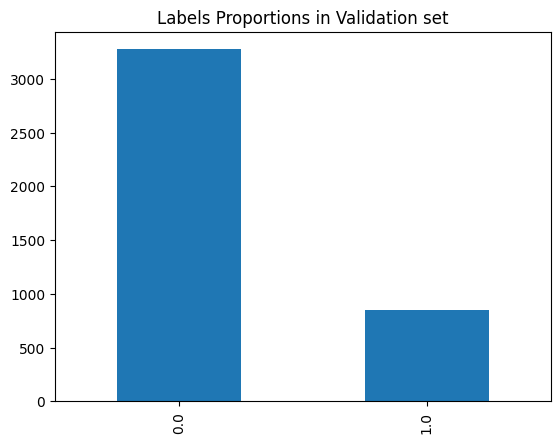

In [71]:
df_val['label'].value_counts().plot.bar(title='Labels Proportions in Validation set')

In [72]:
# Concatenate topics and keypoints, as stated in the paper
df_train = data_handler.concatenate_topics(df_train)
df_val = data_handler.concatenate_topics(df_val)

In [73]:
df_train.info()
print('--------')
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16508 entries, 0 to 16507
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   args        16508 non-null  object 
 1   key_points  16508 non-null  object 
 2   labels      16508 non-null  float64
dtypes: float64(1), object(2)
memory usage: 387.0+ KB
--------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4127 entries, 0 to 4126
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   args        4127 non-null   object 
 1   key_points  4127 non-null   object 
 2   labels      4127 non-null   float64
dtypes: float64(1), object(2)
memory usage: 96.9+ KB


In [86]:
df_train = df_train[13050:13150]
df_train = df_train.reset_index()
df_train[:100]

,index,args,key_points,labels
0,13050,the cost of vocational education far outweighs...,We should subsidize vocational education subsi...,0.0
1,13051,cloning science can lead to many other technol...,We should ban human cloning Cloning can be use...,0.0
2,13052,the worst of the worst have nowhere else to go...,We should close Guantanamo Bay detention camp ...,0.0
3,13053,many people are suffering terribly but are phy...,Assisted suicide should be a criminal offence ...,0.0
4,13054,cannabis has been shown to negatively affect t...,We should legalize cannabis Cannabis is a gate...,0.0
...,...,...,...,...
95,13145,it can be viewed as undemocratic to force peop...,We should introduce compulsory voting Citizens...,1.0
96,13146,cannabis is not a dangerous drug such as meth ...,We should legalize cannabis Alcohol and tobacc...,1.0
97,13147,Parents should be able to plan out their famil...,We should legalize sex selection It is within ...,1.0
98,13148,We should not legalize cannabis as it has been...,We should legalize cannabis Cannabis harms the...,1.0


In [87]:
n_words = pd.DataFrame()
n_words['words_per_arg_train'] = df_train['args'].str.split().apply(len)
n_words['words_per_arg_val'] = df_val['args'].str.split().apply(len)
n_words['words_per_kp_train'] = df_train['key_points'].str.split().apply(len)
n_words['words_per_kp_val'] = df_val['key_points'].str.split().apply(len)

Considerazioni varie...

<AxesSubplot: >

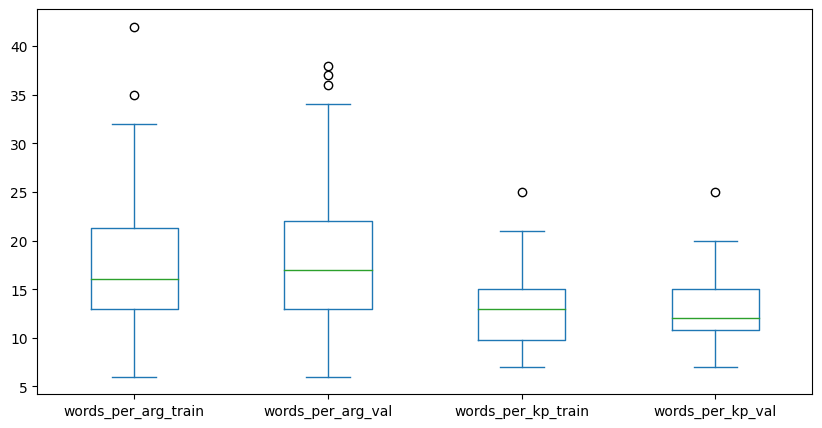

In [88]:
n_words.plot.box(figsize=(10, 5))

In [89]:
# Load our model's (bert-base-uncased) tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenize data
tokenized = data_handler.tokenize_df(df_train[:100], tokenizer)

/storagenfs/m.melerocavallo/HLTKeyPointAnalysis/venv2/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [90]:
print(f'Vocabulary size of tokenizer:', tokenizer.vocab_size, '\nContext size:', tokenizer.model_max_length)

Vocabulary size of tokenizer: 30522 
Context size: 512


In [91]:
model = SiameseNetwork(bert_type=BertModel.from_pretrained('bert-base-uncased'))

batch_size = 32

train_loader = DataLoader(tokenized, shuffle=True, batch_size=batch_size)

#train_loss = ContrastiveLoss()
train_loss = losses.ContrastiveLoss()

optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Batch size: 16, 32
# Learning rate (Adam): 5e-5, 3e-5, 2e-5
# Number of epochs: 2, 3, 4

# The BERT authors recommend between 2 and 4.
epochs = 1

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_loader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [92]:
'''
-y  log(^y) + (1 - y)  log(1 - ^y)
where ^y is the cosine similarity of the embeddings,
and y reflects whether a pair matches (1) or not (0).
'''

import numpy as np
def paper_contrastive(cosine, label):
    
    #cosine[cosine == 0] = 1e-8
    #cosine[cosine == 1] = 0.99
    
    log_1 = torch.nan_to_num(torch.log(cosine), nan=-1e5)
    log_2 = torch.nan_to_num(torch.log(1-cosine), nan=-1e5)
    
    #print(f'cosine {log_1.shape} {log_2.shape}')
    
    contr = torch.mul((-label).double(), log_1.double())+ \
            torch.mul((1-label).double(), log_2.double())
    return contr

In [93]:
model.train()
epoch=1
for batch_idx, (encodings) in enumerate(train_loader):
  #images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)

  # Extract arguments, key_points and labels all from the same batch
    args = encodings['arg']
    kps = encodings['kp']
    labels = encodings['label']

    optimizer.zero_grad()
    output1, output2 = model(args, kps, labels)
        
    # AVG of every token
    output1 = torch.mean(output1, 1)
    output2 = torch.mean(output2, 1)
    
    cos = torch.nn.CosineSimilarity()
    cosine_sim = cos(output1, output2)
    
    print(args['input_ids'].shape[0])
    loss = torch.Tensor(args['input_ids'].shape[0], 1)
    for i in range(0, cosine_sim.shape[0]):
        loss[i] = paper_contrastive(cosine_sim[i], labels[i])
    #loss_function(output1, output2, labels)
    print(loss.shape)


    #loss = loss_function(tf.convert_to_tensor(labels.numpy()), tf.convert_to_tensor(outputs.numpy()))
    loss.mean().backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

    if batch_idx>-1:
        print(f'Train Epoch:', epoch, 'batch:',
            batch_idx, 'loss:',
            loss.mean())

32
torch.Size([32, 1])
Train Epoch: 1 batch: 0 loss: tensor(-1.1666, grad_fn=<MeanBackward0>)
32
torch.Size([32, 1])
Train Epoch: 1 batch: 1 loss: tensor(-1.1770, grad_fn=<MeanBackward0>)
32
torch.Size([32, 1])
Train Epoch: 1 batch: 2 loss: tensor(-0.8133, grad_fn=<MeanBackward0>)
4
torch.Size([4, 1])
Train Epoch: 1 batch: 3 loss: tensor(-0.6171, grad_fn=<MeanBackward0>)


In [102]:
test = DataLoader(tokenized[45:55], shuffle=True)

In [103]:
for batch_idx, (encodings) in enumerate(test):
  #images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)

  # Extract arguments, key_points and labels all from the same batch
    args = encodings['arg']
    kps = encodings['kp']
    labels = encodings['label']

    optimizer.zero_grad()
    output1, output2 = model(args, kps, labels)
        
    # AVG of every token
    output1 = torch.mean(output1, 1)
    output2 = torch.mean(output2, 1)
    
    cos = torch.nn.CosineSimilarity()
    cosine_sim = cos(output1, output2)
    print(f'cosine {cosine_sim} == {labels}')
    
    print(args['input_ids'].shape[0])
    loss = torch.Tensor(args['input_ids'].shape[0], 1)
    for i in range(0, cosine_sim.shape[0]):
        loss[i] = paper_contrastive(cosine_sim[i], labels[i])
    #loss_function(output1, output2, labels)
    print(f'loss: {loss}')

cosine tensor([0.9415], grad_fn=<SumBackward1>) == tensor([0.], dtype=torch.float64)
1
loss: tensor([[-2.8395]], grad_fn=<CopySlices>)
cosine tensor([0.9444], grad_fn=<SumBackward1>) == tensor([1.], dtype=torch.float64)
1
loss: tensor([[0.0572]], grad_fn=<CopySlices>)
cosine tensor([0.9626], grad_fn=<SumBackward1>) == tensor([1.], dtype=torch.float64)
1
loss: tensor([[0.0381]], grad_fn=<CopySlices>)
cosine tensor([0.9434], grad_fn=<SumBackward1>) == tensor([0.], dtype=torch.float64)
1
loss: tensor([[-2.8713]], grad_fn=<CopySlices>)
cosine tensor([0.9280], grad_fn=<SumBackward1>) == tensor([1.], dtype=torch.float64)
1
loss: tensor([[0.0748]], grad_fn=<CopySlices>)
cosine tensor([0.9598], grad_fn=<SumBackward1>) == tensor([0.], dtype=torch.float64)
1
loss: tensor([[-3.2129]], grad_fn=<CopySlices>)
cosine tensor([0.9133], grad_fn=<SumBackward1>) == tensor([0.], dtype=torch.float64)
1
loss: tensor([[-2.4459]], grad_fn=<CopySlices>)
cosine tensor([0.9413], grad_fn=<SumBackward1>) == tensor(

In [ ]:
for epoch in range(1, epochs + 1):
    train(model, None, train_loader, ContrastiveLoss, optimizer, epoch, scheduler)
    #test(model, device, test_loader)


In [78]:
def ContrastiveLoss(output1, output2, labels):
    
    loss = torch.tensor(0.0)
    
    for i in range(output1.size(0)):
    
        loss += compute_contrastive_loss(output1[i], output2[i], labels[i].resize(1), 0.1)
        print(loss)
    
    return loss